# FitHome Leaks V001
This notebook reads in data that has been collected from a FitHome monitor during the learning process and determines:
- The size of the (constant) electricity leak in watts.
- The amount of kWh of electricity wasted in one year.
- The $ amount spent by the homeowner on electricity leaks
- The percentage of total electricity use that is due to leaking.

# Importance of Plugging Leaks

A [study by the NRDC](https://www.nrdc.org/resources/home-idle-load-devices-wasting-huge-amounts-electricity-when-not-active-use) found the homes in the study on average wasted nearly 23% of their electricity consumption on devices that were not being used but were slurping up electricity.

After HVAC, Leaks are one of the largest consumers of electricity.








In [0]:
import pandas as pd

# Data from Firebase
Retrieve the readings into a json file.

In [4]:
%%time
!curl 'https://fithome-9ebbd.firebaseio.com/flower-09282019/readings.json?print=pretty' > monitor.json  

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.9M  100 14.9M    0     0  29.0M      0 --:--:-- --:--:-- --:--:-- 29.0M
CPU times: user 16.9 ms, sys: 4.2 ms, total: 21.1 ms
Wall time: 1.28 s


In [7]:
# @title Put into a Pandas dataframe
# This can take >= 3 minutes.
%%time
df_needs_reshape = pd.read_json("monitor.json","r", encoding="utf8")
df_reshaped = df_needs_reshape.T
df_reshaped.head()

CPU times: user 3min 23s, sys: 3.84 s, total: 3min 27s
Wall time: 3min 22s


In [0]:
# The datetime is in UTC time.  We are in Kirkland, WA
df_reshaped.index = df_reshaped.index.tz_localize('UTC').tz_convert('US/Pacific')


In [9]:
# @title Start Date and End Data of Series
print('Start date: {}'.format(df_reshaped.index.min()))
print('End   date: {}'.format(df_reshaped.index.max()))
time_between = df_reshaped.index.max() - df_reshaped.index.min()
print('\n\nElapsed time: {}'.format(time_between))

Start date: 2019-10-11 13:46:35-07:00
End   date: 2019-10-28 04:58:29-07:00


Elapsed time: 16 days 15:11:54


# Describe the Data
Let's look at some interesting stats

In [10]:
# @title Interesting Data Stats
df_reshaped.describe()

,I,P
count,261938.000000,261938.000000
mean,6.235875,668.917291
std,4.869059,550.091511
min,0.002000,0.000320
25%,2.523000,259.312175
50%,4.381000,484.677050
75%,9.540750,963.062700
max,52.895000,5663.446000


# Leakage as Percent of Total
__How much of the total amount of electricity used in the past 24 - 48 hours is due to leakage?__

- Use the average value of each kWh that has at least 600 samples for the latest 24 to 48 hours.  
  - By bounding the kWh to between 24 and 48 hours, we can help the homeowner determine how well their changes to stop electricity leaks is working.
  - If there are not at least 600 samples per hour, we feel it doesn't have enough samples to represent the hour.  We won't use that hour in our averaging.

## Total Energy
Get the average total energy used within the last 24 - 48 hours.



In [17]:
all_power_data = df_reshaped['P']
# Convert readings to kWh
p_kWh = all_power_data.resample(rule='H').mean()/1000
# Set criteria for hourly data to include at least 600 samples.
enough_samples = all_power_data.resample(rule='H').count() > 600
# Remove hours that don't have enough samples.
p_kWh = p_kWh[enough_samples]
# Bound the readings to the last 24 - 48 hours.
hours_with_enough_samples = len(p_kWh)
if (hours_with_enough_samples < 24):
    print('--> ERROR: We only have {} hours of readings. We need at least 24 hours.'.format(hours_with_enough_samples))
else:
    hours_to_use = hours_with_enough_samples if hours_with_enough_samples < 48 else 48
# Isolate these rows from all hours.
p_kWh_leakage = p_kWh[-hours_to_use:]
# Take the average of these readings.
average_power_during_hours_to_use = p_kWh_leakage.mean()
print('***************************\nThe average amount of energy used per hour during leakage measurements is {}kWh.\n***************************'.format(average_power_during_hours_to_use))







***************************
The average amount of energy used per hour during leakage measurements is 0.7791011826961038kWh.
***************************


## Amount of Leakage
The amount of leakage will be determined by dividing the readings into 1,000 frequency bins and then taking the average of the bin with the highest number of readings.

Let's first look at a box plot of the readings.
### Box Plot
The box plot gives us a quick summary on how the readings are distributed.

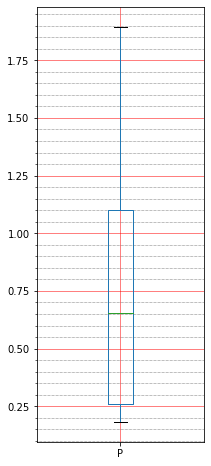

In [19]:
# @title Box Plot
ax = p_kWh_leakage.plot.box(figsize=(3,8))
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

### Calculation
After putting the readings into 1,000 bins, we take the first bin to identify the amount of electricity that leaks.

First, let's look at a histogram of the frequency distribution.
#### Histogram

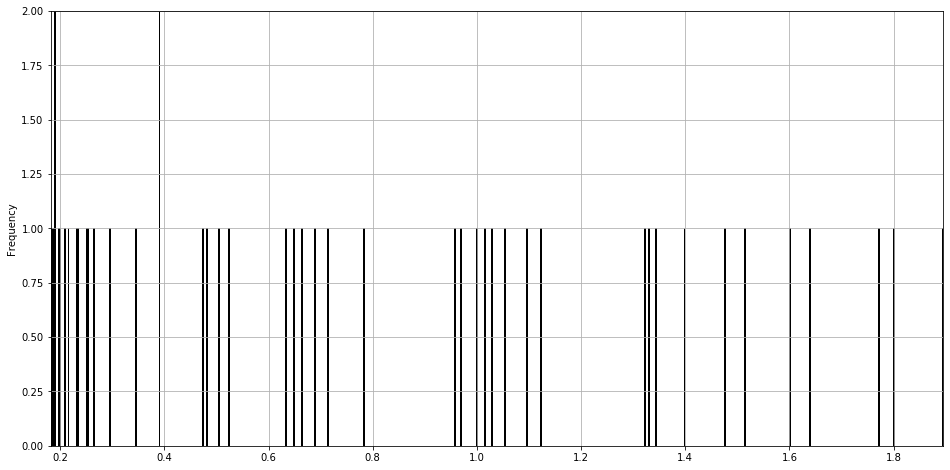

In [20]:
 p_kWh_leakage.plot.hist(bins=1000, grid=True, edgecolor='k',figsize=(16,8)).autoscale(enable=True, axis='both', tight=True)

In [32]:

# @title Determine amount Leaking
df_bins = df_reshaped['P'].value_counts(bins=1000)

left_bin = df_bins.index[0].left
right_bin = df_bins.index[0].right

amount_leaking = int(round((right_bin + left_bin) / 2))
leakage_kWh = amount_leaking/1000*24*365
yearly_cost = round(.13*leakage_kWh,2)

print('Highest Frequency bins: \n{}'.format(df_bins.head(10)))
print('\n***************\nAmount of electricity leakage: {}w\n***************\n'.format(amount_leaking))
print('\n***************\nAmount of power leaked per year: {}kWh\n***************\n'.format(leakage_kWh))
print('\n***************\nCost per year at $.13/kWh: ${}\n***************\n'.format(yearly_cost))


Highest Frequency bins: 
(158.577, 164.24]     10866
(152.913, 158.577]    10347
(164.24, 169.904]      7581
(254.855, 260.519]     5918
(169.904, 175.567]     5646
(260.519, 266.182]     5337
(249.192, 254.855]     3981
(226.538, 232.202]     3116
(266.182, 271.846]     2813
(504.047, 509.71]      2809
Name: P, dtype: int64

***************
Amount of electricity leakage: 161w
***************


***************
Amount of power leaked per year: 1410.36kWh
***************


***************
Cost per year at $.13/kWh: $183.35
***************



# Total Amount of Average Power Due to Leakage
We can now figure out how much of our electricity use is being sucked up by devices when we're not using them.

In [36]:
leakage_percent = round(amount_leaking/1000/average_power_during_hours_to_use*100,2)
print('\n***************\nPercent of the total electricity used is being leaked: {}%\n***************\n'.format(leakage_percent))


***************
Percent of the total electricity used is being leaked: 20.66%
***************

